**COMP5318Assignment2-Binaray Classification on Sentiment140**

Group 84,SID1:  SID2:

**1.Import libraries related**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#import
!pip install pandas numpy nltk scikit-learn tensorflow keras-tuner
import pandas as pd
import numpy as np
np.random.seed(42)

import re
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from matplotlib import pyplot as plt

import gensim.downloader as api
from keras.utils import pad_sequences


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import CategoricalNB
import tensorflow as tf
import keras
import keras_tuner as kt
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, Bidirectional

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to C:\Users\Gao
[nltk_data]     Hongkai\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Gao
[nltk_data]     Hongkai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Gao
[nltk_data]     Hongkai\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**2.Pre-process the dataset**

> Read dataset.

  In this task, we decide to use just two columns,'sentiment' and 'text', to make the dataset smaller and less computation.





In [6]:
# Load the dataset from csv
mydf=pd.read_csv('/content/drive/MyDrive/training.300000.processed.noemoticon.csv',encoding='utf-8')
#mydf=pd.read_csv('training.300000.processed.noemoticon.csv',encoding='utf-8')
# Examine what is in the dataset
print(mydf.iloc[:,[0,-1]].head(10))
# Extract 2 columns [sentiment,text] into next stage
dataset=mydf.iloc[:,[0,-1]]
sentiment_count=dataset['sentiment'].value_counts()
print(f'Sentiment column contanins: \n{sentiment_count}')
dataset['sentiment'] = dataset['sentiment'].replace(4, 1)
print(f'The shape of total dataset is:{dataset.shape}')

   sentiment                                               text
0          0             @chrishasboobs AHHH I HOPE YOUR OK!!! 
1          0  @misstoriblack cool , i have no tweet apps  fo...
2          0  @TiannaChaos i know  just family drama. its la...
3          0  School email won't open  and I have geography ...
4          0                             upper airways problem 
5          0         Going to miss Pastor's sermon on Faith... 
6          4            on lunch....dj should come eat with me 
7          0   @piginthepoke oh why are you feeling like that? 
8          0    gahh noo!peyton needs to live!this is horrible 
9          4  @mrstessyman thank you glad you like it! There...
Sentiment column contanins: 
sentiment
4    150515
0    149485
Name: count, dtype: int64
The shape of total dataset is:(300000, 2)


> Data cleaning

From previous section , we can see that the sentiment is a **numeric** one and consist of 0 and 4, thus only need to replace **4** with **1**.

While for the text column, the filename says it do not have emoticons, so we decide to remove noise and irrelevant information from the tweets, such as punctuation, URLs, hashtags, mentions, etc.

After that is **tokenization**, *stopwords removal, stemming and lemmatizing*.
Noticed that only **tokenization** is a must.

In [7]:
sw=stopwords.words('english')
stemmer = nltk.stem.porter.PorterStemmer()
lemmatizer = nltk.stem.WordNetLemmatizer()
# Cleaning text
def Cleaning(document,stem_lemma=False):
  # 1.Lowercase
  document=document.lower()
  # 2.Remove unnecessary chars with RE
  document = re.sub(r'@\S+', ' ', document)#remove the @
  document = re.sub(r'http\S+', ' ', document)#remove the URL
  document = re.sub(r'[^\w\s]', ' ', document)#remove punctuation
  # 3.Tokenization based on words
  tokens=nltk.word_tokenize(document)
  # 4.Use NLKT to remove stopwords
  tokens=[word for word in tokens if word not in sw]
  if stem_lemma:
    # 5.Use PorterStemmer to do stem 
    tokens=[stemmer.stem(word) for word in tokens]
    # 6.Use wordnet to do lemmatizing  
    tokens=[lemmatizer.lemmatize(word) for word in tokens]
  return " ".join(tokens)
dataset.text = dataset.text.apply(lambda x: Cleaning(x,True))
print(dataset.head(10))

   sentiment                                               text
0          0                                       ahhh hope ok
1          0                              cool tweet app razr 2
2          0  know famili drama lame hey next time u hang ki...
3          0  school email open geographi stuff revis stupid...
4          0                               upper airway problem
5          0                        go miss pastor sermon faith
6          1                                  lunch dj come eat
7          0                                       oh feel like
8          0                  gahh noo peyton need live horribl
9          1  thank glad like product review bit site enjoy ...


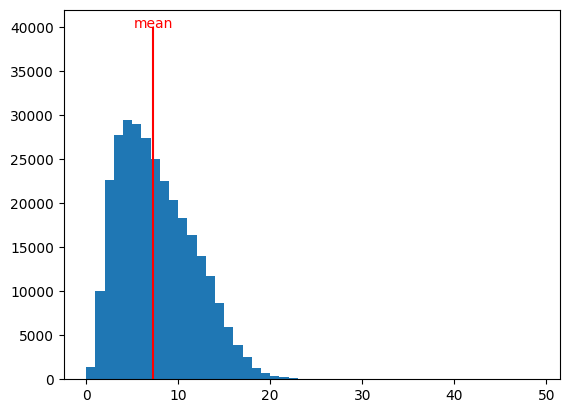

In [8]:
len_array=[len(line.split()) for line in dataset['text']]
len_mean = np.mean(len_array)
plt.hist(len_array,range(0,50))
plt.annotate("mean", xy=(len_mean, 40000), xytext=(len_mean-2, 40000),color='r')
plt.vlines(len_mean, 0, 40000, color = 'r')
plt.show()



> Train,test split (0.8,0.2)



In [9]:
TRAIN_SIZE = 0.8
X_train, X_test, y_train, y_test = train_test_split(dataset['text'],dataset['sentiment'], test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(X_train))
print("TEST size:", len(X_test))

TRAIN size: 240000
TEST size: 60000


Preprocess the data for the **logistic regression**

---



In [10]:
#change text to numeric 
to_vec = CountVectorizer()
X_train_vec = to_vec.fit_transform(X_train)
X_test_vec = to_vec.transform(X_test)



> Word embedding(with padding)

Turn all the tweets into documents 


In [11]:
documents = [text.split() for text in X_train]
print(f'Check whether the split works:{documents[0]}')

Check whether the split works:['readi', 'anoth', 'week', 'glad', 'go', 'work', 'wonder', 'car', 'start']


In [12]:
import gensim
W2V_SIZE = 25
W2V_WINDOW = 7
W2V_EPOCH = 16
W2V_MIN_COUNT = 5



w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE,window=W2V_WINDOW,min_count=W2V_MIN_COUNT,workers=8)

In [13]:
w2v_model.build_vocab(documents)
words = list(w2v_model.wv.index_to_key)
vocab_size = len(words)
print(f'Total vocabulary size is:{vocab_size}')

Total vocabulary size is:14183


In [14]:
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

(24034024, 27701984)

Validation:See how our model works. Here we choose word 'nintendo' as an example.

In [15]:
w2v_model.wv.most_similar("nintendo")

[('psp', 0.8485073447227478),
 ('microsoft', 0.8312132954597473),
 ('exclus', 0.829622209072113),
 ('soni', 0.8267709612846375),
 ('keynot', 0.8261277079582214),
 ('l4d', 0.8232858180999756),
 ('pirat', 0.8114590644836426),
 ('demo', 0.7963566780090332),
 ('zelda', 0.7883288860321045),
 ('sl', 0.7854371666908264)]

Tokenizing using keras.Tokenizer

In [16]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train) 
# Updates internal vocabulary based on a list of texts. This method creates the vocabulary index based on word frequency

vocab_size = len(tokenizer.word_index) + 1
print(f'Total words in training_text:{vocab_size}')

Total words in training_text:73295


Do the padding here. Currently we pad '0' into those tweets with inadequate length.

SEQUENCE_LENGTH here is a parameter to change.

Turn word into vector.

In [17]:
from keras.utils import pad_sequences

# text_to_sequences transforms each text in texts to a sequence of integers. 
#So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary

SEQUENCE_LENGTH = 15

X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=SEQUENCE_LENGTH)  
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=SEQUENCE_LENGTH)

#pad_sequences is used to ensure that all sequences in a list have the same length

**3. Model creation**


> Logstics regression



In [18]:
#logic regression

mylogre = LogisticRegression(max_iter=7000)
mylogre.fit(X_train_vec, y_train)

LogisticRegression(max_iter=7000)

In [20]:
#use model to get the prediction and evaluate it
y_pred_lr = mylogre.predict(X_test_vec)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy: {accuracy_lr*100:.4f}%")

Accuracy: 76.5283%




> LSTM



In [21]:
OOV_VALUE=np.random.uniform(low=-1.0, high=1.0, size=(W2V_SIZE,))
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
  else:
    embedding_matrix[i]= OOV_VALUE
print(embedding_matrix.shape)

embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)
#we build the embedding layer to map from words to vectors which you can do better analysis

(73295, 25)


In [23]:
tf.keras.backend.clear_session()
from keras.models import Sequential

model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.4))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),   #Reduce learning rate when a metric has stopped improving. 
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]    #Stop training when a monitored metric has stopped improving.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 25)            1832375   
                                                                 
 dropout (Dropout)           (None, 15, 25)            0         
                                                                 
 lstm (LSTM)                 (None, 100)               50400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 1,882,876
Trainable params: 50,501
Non-trainable params: 1,832,375
_________________________________________________________________


In [24]:
BATCH_SIZE = 64
EPOCHS = 4            #there should be more but for the sake of time let's just do 1 epoch

history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/4
3375/3375 [==============================] - 137s 40ms/step - loss: 0.5694 - accuracy: 0.6993 - val_loss: 0.5127 - val_accuracy: 0.7427 - lr: 0.0010
Epoch 2/4
3375/3375 [==============================] - 161s 48ms/step - loss: 0.5515 - accuracy: 0.7140 - val_loss: 0.5080 - val_accuracy: 0.7480 - lr: 0.0010
Epoch 3/4
3375/3375 [==============================] - 167s 50ms/step - loss: 0.5460 - accuracy: 0.7182 - val_loss: 0.5087 - val_accuracy: 0.7492 - lr: 0.0010
Epoch 4/4
3375/3375 [==============================] - 172s 51ms/step - loss: 0.5413 - accuracy: 0.7215 - val_loss: 0.5034 - val_accuracy: 0.7509 - lr: 0.0010


In [ ]:
tf.keras.backend.clear_session()
from keras.models import Sequential
model_bi = Sequential()
model_bi.add(embedding_layer)
model_bi.add(Dropout(0.4))
model_bi.add(Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2,return_sequences=True)))
model_bi.add(Bidirectional(LSTM(32)))
model_bi.add(Dense(1, activation='sigmoid'))

model_bi.summary()
model_bi.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),   #Reduce learning rate when a metric has stopped improving. 
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]    #Stop training when a monitored metric has stopped improving.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 25)            1832375   
                                                                 
 dropout (Dropout)           (None, 20, 25)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 20, 128)          46080     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,977,400
Trainable params: 145,025
Non-tr

In [ ]:
BATCH_SIZE = 128
EPOCHS = 4            

history = model_bi.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
844/844 [==============================] - 183s 207ms/step - loss: 0.5785 - accuracy: 0.6926 - val_loss: 0.5133 - val_accuracy: 0.7425 - lr: 0.0010
Epoch 2/8
844/844 [==============================] - 177s 209ms/step - loss: 0.5631 - accuracy: 0.7029 - val_loss: 0.5099 - val_accuracy: 0.7442 - lr: 0.0010
Epoch 3/8
844/844 [==============================] - 175s 208ms/step - loss: 0.5555 - accuracy: 0.7098 - val_loss: 0.5042 - val_accuracy: 0.7497 - lr: 0.0010
Epoch 4/8
844/844 [==============================] - 181s 214ms/step - loss: 0.5501 - accuracy: 0.7137 - val_loss: 0.5019 - val_accuracy: 0.7511 - lr: 0.0010
Epoch 5/8
844/844 [==============================] - 176s 209ms/step - loss: 0.5480 - accuracy: 0.7149 - val_loss: 0.5024 - val_accuracy: 0.7515 - lr: 0.0010
Epoch 6/8
844/844 [==============================] - 176s 208ms/step - loss: 0.5442 - accuracy: 0.7162 - val_loss: 0.4980 - val_accuracy: 0.7552 - lr: 0.0010
Epoch 7/8
844/844 [==============================] -

Bi-LSTM

**4.Fine-tune for best hyperparameter**

GridSearch is a good hyper-param tunning method, so we use it to find best parameter for logistic regression.

In [11]:
from sklearn.model_selection import GridSearchCV
param_lr = {
    'C':list(np.linspace(0.05,1,10,20)),
    'solver':['liblinear','sag','newton-cg','lbfgs']}

GS = GridSearchCV(mylogre,param_lr,cv=10)
GS.fit(X_train_vec,y_train)
#输出最优参数
GS.best_params_


{'C': 0.2611111111111111, 'solver': 'lbfgs'}

So, it shows that the best parameter in our choice for C and solver is 0.261111 and lbfgs. 

We can update the logistic regression:

In [12]:
mylogre = LogisticRegression(max_iter=7000, C = 0.26111111, solver = 'lbfgs')
mylogre.fit(X_train_vec, y_train)

LogisticRegression(C=0.26111111, max_iter=7000)

We use keras_tuner to do the automatic hyperparameter tuning.

In [ ]:
def lstm_model_builder(hp):
  model = keras.Sequential()
  model.add(embedding_layer)

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  model.add(Dropout(0.4))
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(LSTM(units=hp_units, dropout=0.2, recurrent_dropout=0.2))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  return model


tuner = kt.Hyperband(lstm_model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='lstm_to_kt')
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),   #Reduce learning rate when a metric has stopped improving. 
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]    #Stop training when a monitored metric has stopped improving.

tuner.search(X_train, y_train, epochs=20, validation_split=0.1,batch_size=64, callbacks=callbacks)

# Get the optimal hyperparameters
best_lstmhps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the LSTM is {best_lstmhps.get('units')}.
""")


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
480               |480               |units
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
 372/3375 [==>...........................] - ETA: 11:05 - loss: 0.5999 - accuracy: 0.6717

In [ ]:
def bi_model_builder(hp):
  model = keras.Sequential()
  model.add(embedding_layer)

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  model_.add(Dropout(0.4))
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(Bidirectional(LSTM(units=hp_units, dropout=0.2, recurrent_dropout=0.2,return_sequences=True)))
  model.add(Bidirectional(LSTM(units=hp_units)))
  model.add(Dense(1, activation='sigmoid'))


  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  return model

tuner = kt.Hyperband(bi_model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='bilstm_to_kt')
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),   #Reduce learning rate when a metric has stopped improving. 
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]    #Stop training when a monitored metric has stopped improving.

tuner.search(X_train, y_train, epochs=20, validation_split=0.1,batch_size=128, callbacks=callbacks)

# Get the optimal hyperparameters
best_bilstmhps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the Bi-LSTM is {best_bilstmhps.get('units')}.
""")

**5.Final Evaluation**

Logistic regression

In [14]:
y_pred_lr = mylogre.predict(X_test_vec)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy: {accuracy_lr*100}%")

Accuracy: 76.87666666666667%


              precision    recall  f1-score   support

           0       0.78      0.74      0.76     29850
           1       0.76      0.79      0.77     30150

    accuracy                           0.77     60000
   macro avg       0.77      0.77      0.77     60000
weighted avg       0.77      0.77      0.77     60000



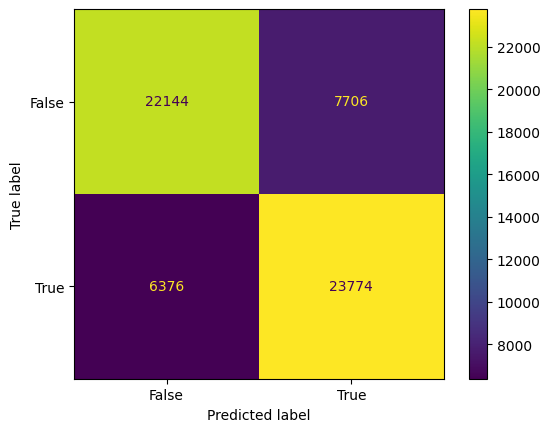

0.7653


In [ ]:
y_pred_lr=[decode_sentiment(i) for i in y_pred_lr]
print(classification_report(y_test_1d, y_pred_lr))
from sklearn.metrics import confusion_matrix
confusion_matrixlr = confusion_matrix(y_test_1d, y_pred_lr)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrixlr, display_labels = [False, True])
cm_display.plot()
plt.show()
print(accuracy_score(y_test_1d, y_pred_lr))



> Lstm



235/235 [==============================] - 9s 37ms/step - loss: 0.4908 - accuracy: 0.7574
ACCURACY:0.7574
LOSS:0.4908
235/235 [==============================] - 6s 22ms/step
              precision    recall  f1-score   support

           0       0.76      0.74      0.75     29850
           1       0.75      0.77      0.76     30150

    accuracy                           0.76     60000
   macro avg       0.76      0.76      0.76     60000
weighted avg       0.76      0.76      0.76     60000



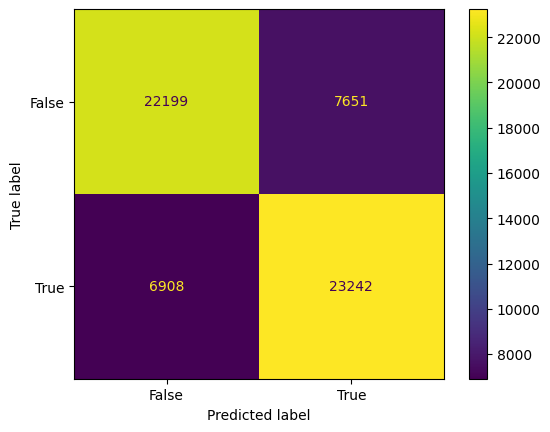

In [ ]:


score = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print(f"ACCURACY:{score[1]:.4f}")
print(f"LOSS:{score[0]:.4f}")
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def decode_sentiment(score):
    if score>=0.5:
      return 1
    else:
      return 0
scores = model.predict(X_test, verbose=1, batch_size=256)
y_test_1d = list(y_test)
y_pred_lstm = [decode_sentiment(score) for score in scores]

print(classification_report(y_test_1d, y_pred_lstm))
confusion_matrix = confusion_matrix(y_test_1d, y_pred_lstm)
from sklearn.metrics import ConfusionMatrixDisplay
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()
print(accuracy_score(y_test_1d, y_pred_lstm))

Bi-LSTM

235/235 [==============================] - 16s 70ms/step - loss: 0.4919 - accuracy: 0.7570
ACCURACY:0.7570
LOSS:0.4919
235/235 [==============================] - 13s 53ms/step
              precision    recall  f1-score   support

           0       0.76      0.76      0.76     29850
           1       0.76      0.76      0.76     30150

    accuracy                           0.76     60000
   macro avg       0.76      0.76      0.76     60000
weighted avg       0.76      0.76      0.76     60000



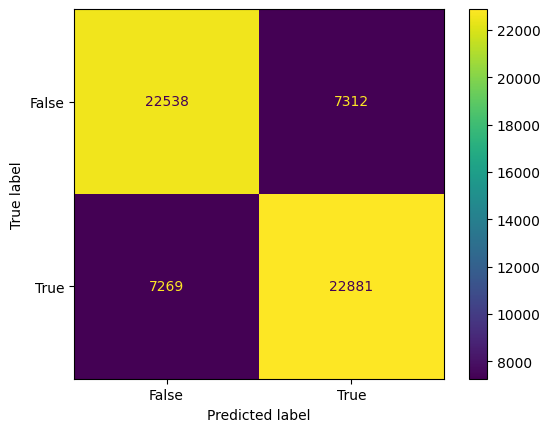

0.7569833333333333


In [ ]:
score_bi = model_bi.evaluate(X_test, y_test, batch_size=BATCH_SIZE)

print(f"ACCURACY:{score_bi[1]:.4f}")
print(f"LOSS:{score_bi[0]:.4f}")
scores_bi = model_bi.predict(X_test, verbose=1, batch_size=256)
y_pred_bi = [decode_sentiment(score) for score in scores_bi]
print(classification_report(y_test_1d, y_pred_bi))
from sklearn.metrics import confusion_matrix
confusion_matrixbi = confusion_matrix(y_test_1d, y_pred_bi)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrixbi, display_labels = [False, True])
cm_display.plot()
plt.show()
print(accuracy_score(y_test_1d, y_pred_bi))